In [71]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

import squarify
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [72]:
df = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [73]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot:>

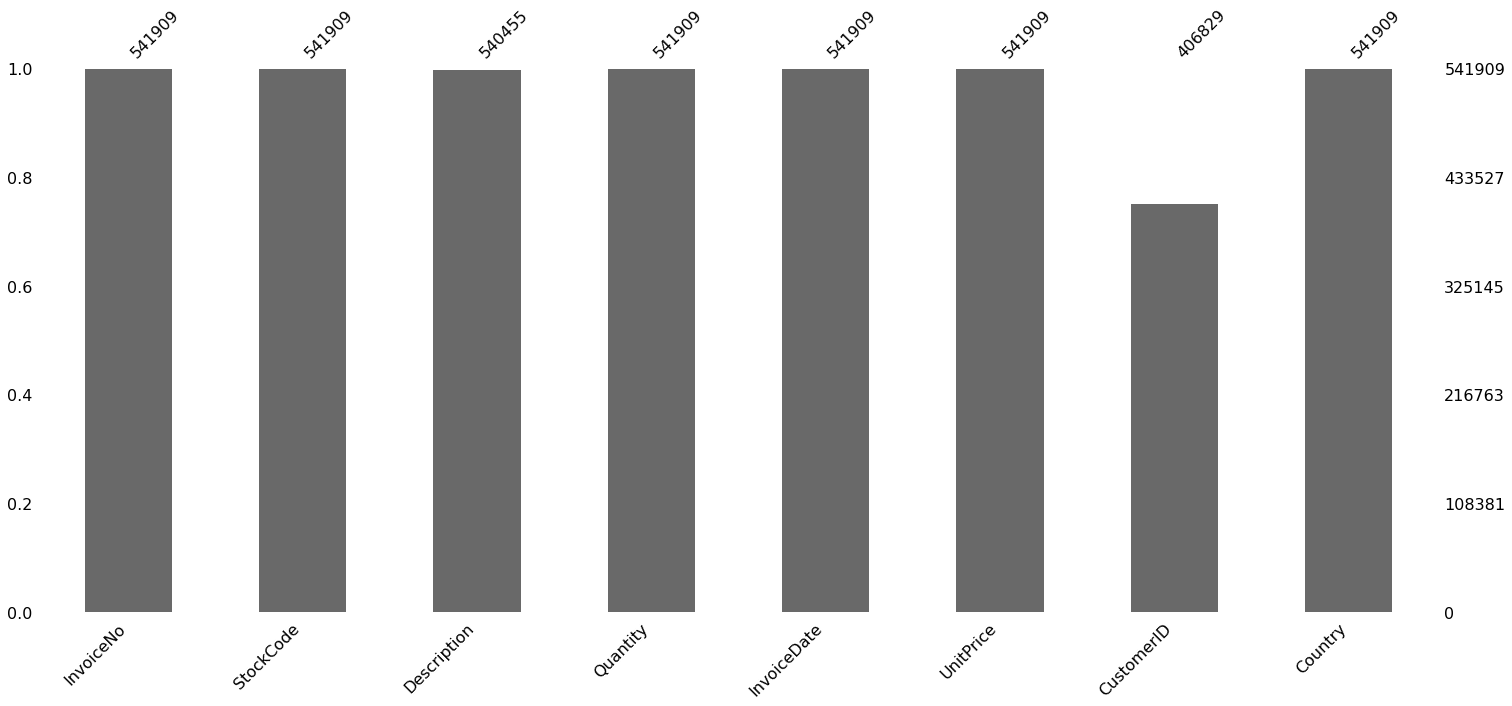

In [74]:
import missingno as msno
msno.bar(df)

In [75]:
df = df.dropna()
df.shape

(406829, 8)

<AxesSubplot:>

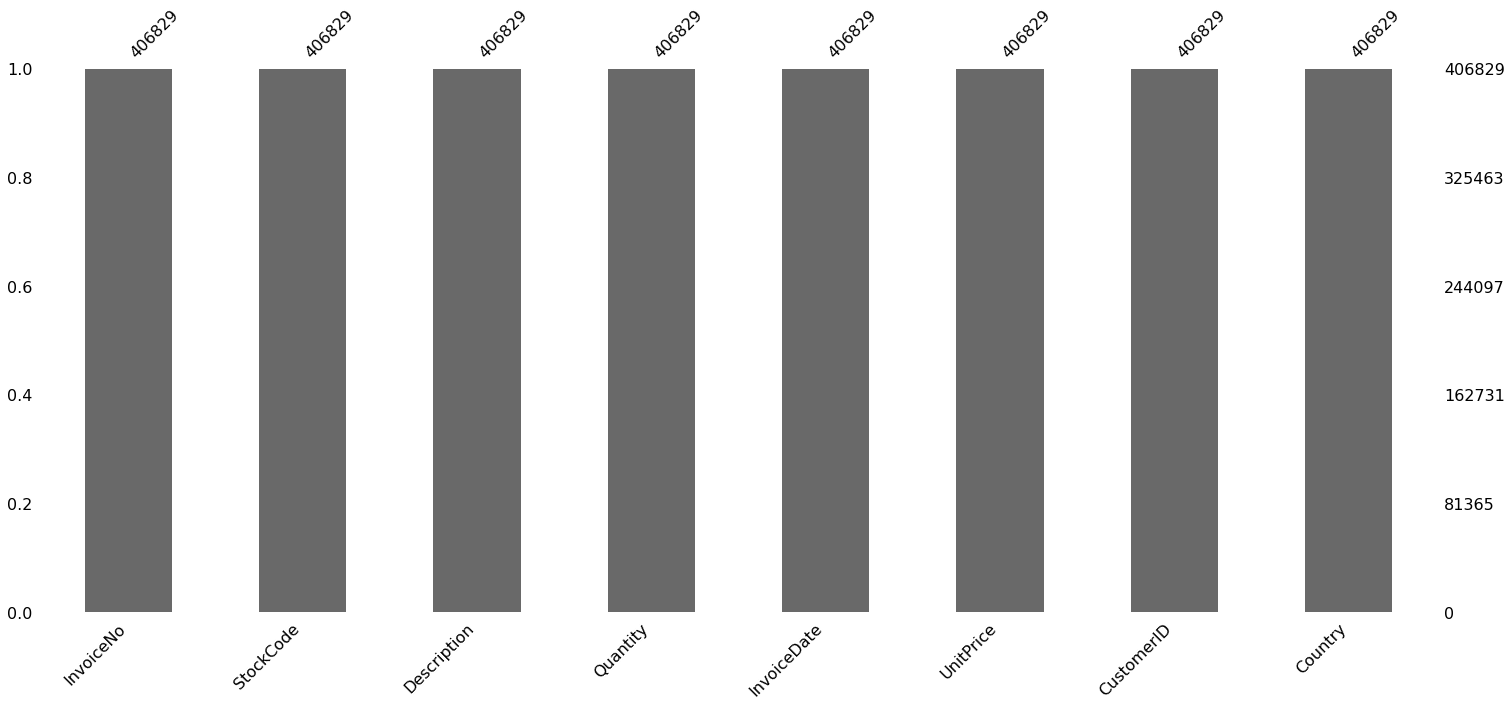

In [76]:
msno.bar(df)

In [77]:
#checking for duplicates
df.duplicated().sum()

5225

In [78]:
#removing duplicates
df.drop_duplicates(keep='first', inplace=True)
df.shape

(401604, 8)

In [79]:
retail = df.copy()

In [80]:
#calculate revenue per row and add new column
retail['Revenue'] = retail['Quantity'] * retail['UnitPrice']

In [81]:
retail.InvoiceDate = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

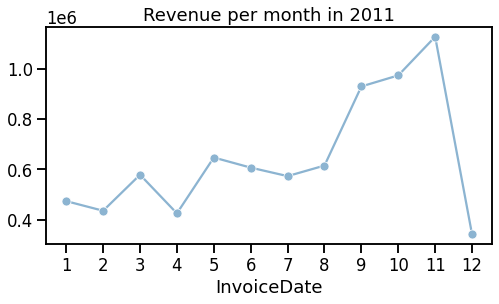

In [82]:
# Let's visualize the top grossing months
retail_month = retail[retail.InvoiceDate.dt.year==2011]
monthly_gross = retail_month.groupby(retail_month.InvoiceDate.dt.month).Revenue.sum()

plt.figure(figsize=(8,4))
sns.set_context("talk")
sns.set_palette("PuBuGn_d")
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o')
plt.xticks(range(1,13))
plt.title("Revenue per month in 2011")
plt.show()

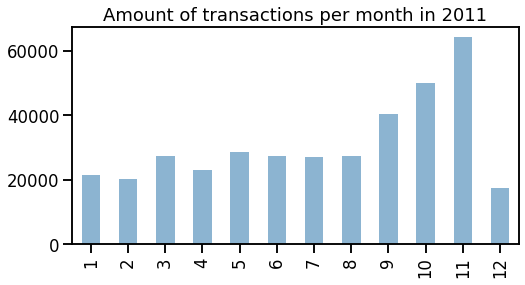

In [83]:
#amount of transactions per month
plt.figure(figsize=(8,4))
retail[retail.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')
plt.title("Amount of transactions per month in 2011")
plt.show()

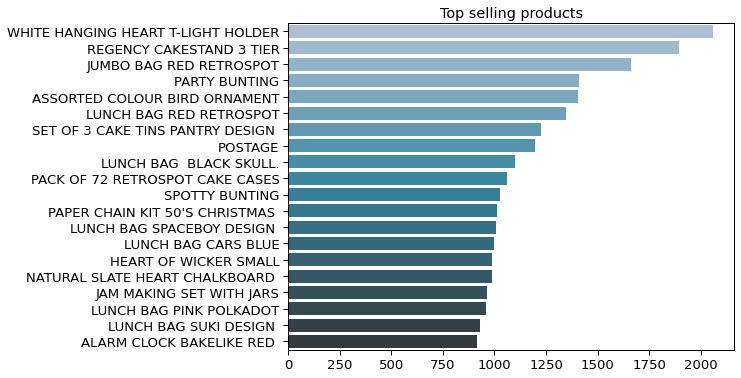

<Figure size 432x288 with 0 Axes>

In [84]:
# Let's visualize some top products from the whole range
top_products = retail['Description'].value_counts()[:20]
plt.figure(figsize=(8,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values, 
           palette='PuBuGn_d')
plt.title("Top selling products")
plt.show()
plt.savefig('top_products.png')

# Data Preparation - RFM Model

In [85]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
#let's look at amount spend per customer (revenue contributed) M-Monetary
retail_mv = retail.groupby(['CustomerID']).agg({'Amount': sum}).reset_index()
retail_mv.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [86]:
#F-frequency (how many purchases each customer made)
retail_f = retail.groupby('CustomerID')['InvoiceNo'].count()
retail_f = retail_f.reset_index()
retail_f.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [87]:
#R-recency 
#last transaction date 

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(retail['InvoiceDate'])

#difference between last date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34,373 days 04:24:00


In [88]:
#merge previous dataframes together (mv+f)
retail_mv_f = pd.merge(retail_mv, retail_f, on='CustomerID', how='inner')
retail_mv_f.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [89]:
#recency per customer (last transaction date)
retail_r = retail.groupby('CustomerID')['Diff'].min()
retail_r = retail_r.reset_index()

# Extract number of days only
retail_r['Diff'] = retail_r['Diff'].dt.days

In [90]:
#merge R dataframe with FM

retail_rfm = pd.merge(retail_mv_f, retail_r, on='CustomerID', how='inner')
retail_rfm.columns = ['CustomerID', 'MonetaryValue', 'Frequency', 'Recency']
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [91]:
# create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(retail_rfm.Recency, q = 4, labels = r_labels)
f_labels = range(1, 5)
f_groups = pd.qcut(retail_rfm.Frequency, q = 4, labels = f_labels)
m_labels = range(1, 5)
m_groups = pd.qcut(retail_rfm.MonetaryValue, q = 4, labels = m_labels)

In [92]:
# make a new column for group labels
retail_rfm['R'] = r_groups.values
retail_rfm['F'] = f_groups.values
retail_rfm['M'] = m_groups.values
# sum up the three columns
retail_rfm['RFM_Segment'] = retail_rfm.apply(lambda x: str(int(x['R'])) + str(int(x['F'])) + str(int(x['M'])), axis = 1)
retail_rfm['RFM_Score'] = retail_rfm[['R', 'F', 'M']].sum(axis = 1)
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score
0,12346.0,0.00,2,325,1,1,1,111,3
1,12347.0,4310.00,182,1,4,4,4,444,12
2,12348.0,1797.24,31,74,2,2,4,224,8
3,12349.0,1757.55,73,18,3,3,4,334,10
4,12350.0,334.40,17,309,1,1,2,112,4


In [93]:
score_labels = ['Green', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(retail_rfm.RFM_Score, q = 4, labels = score_labels)
retail_rfm['RFM_Level'] = score_groups.values
retail_rfm.sort_values(by='RFM_Score', ascending=False)
retail_rfm.head(10)

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,12346.0,0.00,2,325,1,1,1,111,3,Green
1,12347.0,4310.00,182,1,4,4,4,444,12,Gold
2,12348.0,1797.24,31,74,2,2,4,224,8,Silver
3,12349.0,1757.55,73,18,3,3,4,334,10,Silver
4,12350.0,334.40,17,309,1,1,2,112,4,Green
5,12352.0,1545.41,95,35,3,3,3,333,9,Silver
6,12353.0,89.00,4,203,1,1,1,111,3,Green
7,12354.0,1079.40,58,231,1,3,3,133,7,Bronze
8,12355.0,459.40,13,213,1,1,2,112,4,Green
9,12356.0,2811.43,59,22,3,3,4,334,10,Silver


In [94]:
retail_rfm_levels = retail_rfm.groupby('RFM_Level')['CustomerID'].count().reset_index(name='counts')
retail_rfm_levels.head()

,RFM_Level,counts
0,Green,1298
1,Bronze,908
2,Silver,1322
3,Gold,844


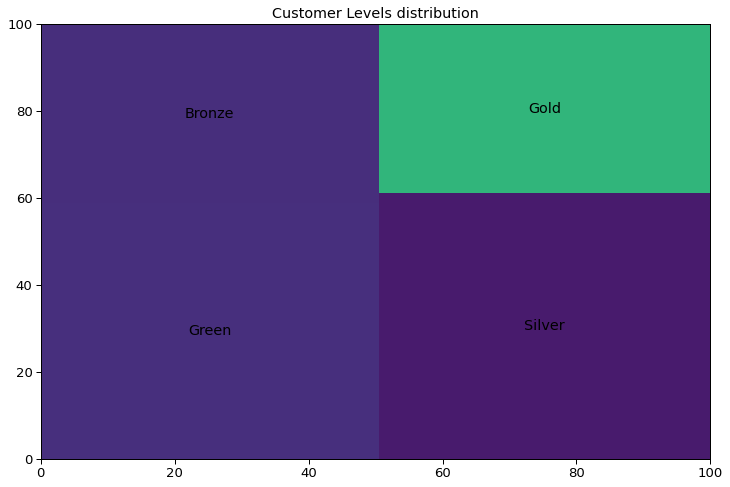

In [95]:
#let's exclude others segment for visualization
levels = list(retail_rfm_levels.RFM_Level)
score = list(retail_rfm_levels.counts)
plt.figure(figsize=(12,8))
plt.title('Customer Levels distribution')
squarify.plot(sizes=score, label=levels)

plt.show()

In [96]:
#let's try to do more detailed segmentation
segment_dict = {    
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Potential Loyalists':'434', # High recency and monetary value, average frequency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'At Risk Customers':'244',   # Customer's shopping less often now who used to shop a lot
    'Can’t Lose Them':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [97]:
# Swap the key and value of dictionary
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

# Allocate segments to each customer as per the RFM score mapping
retail_rfm['Segment'] = retail_rfm.RFM_Segment.map(lambda x: dict_segment.get(x))

In [98]:
# Allocate all remaining customers to others segment category
retail_rfm.Segment.fillna('others', inplace=True)

In [99]:
retail_rfm.sample(10)

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment
3887,17628.0,75.75,5,80,2,1,1,211,4,Green,others
2770,16099.0,731.90,39,49,3,2,3,323,8,Silver,others
3161,16625.0,333.08,23,274,1,2,2,122,5,Green,Lost Cheap Customers
3580,17204.0,1352.91,67,168,1,3,3,133,7,Bronze,others
419,12875.0,343.23,2,142,2,1,2,212,5,Green,others
2311,15469.0,504.50,27,42,3,2,2,322,7,Bronze,others
3134,16591.0,213.50,10,68,2,1,1,211,4,Green,others
2184,15299.0,3787.09,12,66,2,1,4,214,7,Bronze,others
3578,17201.0,289.78,38,53,2,2,1,221,5,Green,others
453,12924.0,929.95,31,87,2,2,3,223,7,Bronze,others


In [100]:
retail_rfm_segments = retail_rfm[retail_rfm.Segment!='other'].groupby('Segment')['CustomerID'].count().reset_index(name='counts')
retail_rfm_segments.iloc[:8]

,Segment,counts
0,At Risk Customers,105
1,Best Customers,470
2,Big Spenders,57
3,Can’t Lose Them,21
4,Lost Cheap Customers,204
5,Loyal Customers,210
6,Potential Loyalists,79
7,Recent Customers,85


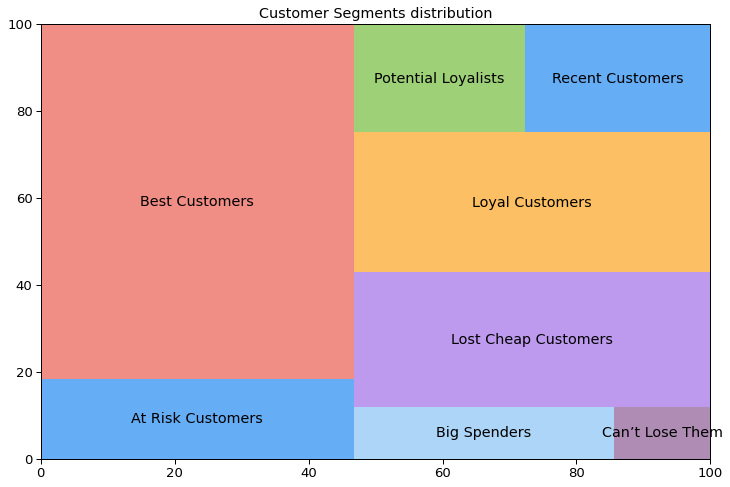

In [101]:
#let's exclude others segment for visualization
segment = list(retail_rfm_segments.iloc[:8].Segment)
score = list(retail_rfm_segments.iloc[:8].counts)
color_list = ["#248af1", "#eb5d50", "#8bc4f6", "#8c5c94", "#a170e8", "#fba521", "#75bc3f"]
plt.figure(figsize=(12,8))
plt.title('Customer Segments distribution')
squarify.plot(sizes=score, label=segment,color=color_list, alpha=0.7)

plt.show()

Text(0.5, 0, 'Attributes')

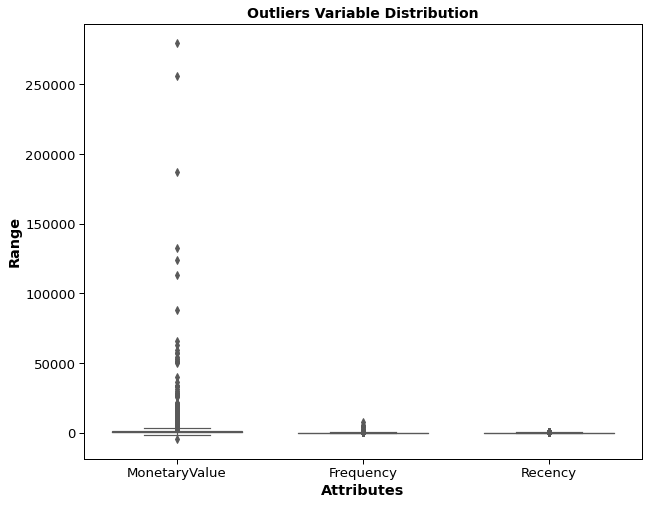

In [102]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['MonetaryValue','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = retail_rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [103]:
# Removing (statistical) outliers for Amount
Q1 = retail_rfm.MonetaryValue.quantile(0.05)
Q3 = retail_rfm.MonetaryValue.quantile(0.95)
IQR = Q3 - Q1
retail_rfm = retail_rfm[(retail_rfm.MonetaryValue >= Q1 - 1.5*IQR) & (retail_rfm.MonetaryValue <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = retail_rfm.Recency.quantile(0.05)
Q3 = retail_rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
retail_rfm = retail_rfm[(retail_rfm.Recency >= Q1 - 1.5*IQR) & (retail_rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = retail_rfm.Frequency.quantile(0.05)
Q3 = retail_rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
retail_rfm = retail_rfm[(retail_rfm.Frequency >= Q1 - 1.5*IQR) & (retail_rfm.Frequency <= Q3 + 1.5*IQR)]

In [104]:
# Rescaling the attributes

retail_rfm_df = retail_rfm[['MonetaryValue', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
retail_rfm_scaled = scaler.fit_transform(retail_rfm_df)
retail_rfm_scaled.shape

(4295, 3)

In [105]:
retail_rfm_scaled = pd.DataFrame(retail_rfm_scaled)
retail_rfm_scaled.columns = ['MonetaryValue', 'Frequency', 'Recency']
retail_rfm_scaled.head()

,MonetaryValue,Frequency,Recency
0,-0.722542,-0.750830,2.302166
1,1.735232,1.057112,-0.906150
2,0.302333,-0.459551,-0.183289
3,0.279700,-0.037698,-0.737813
4,-0.531850,-0.600168,2.143731


# K Means Clustering Algorithm

In [106]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(retail_rfm_scaled)

KMeans(max_iter=50, n_clusters=4)

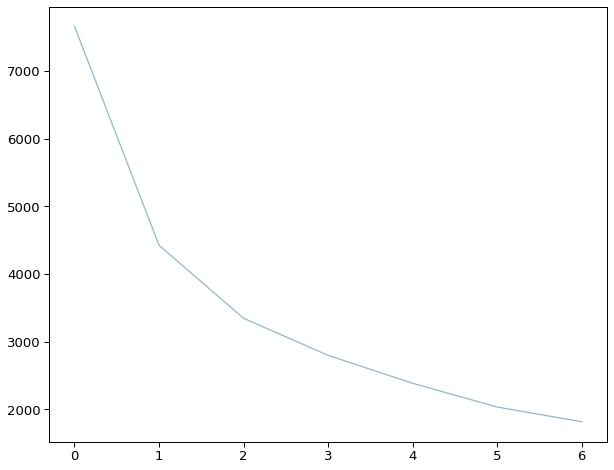

In [107]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(retail_rfm_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Text(0.5, 1.0, 'Error Rate and Clusters')

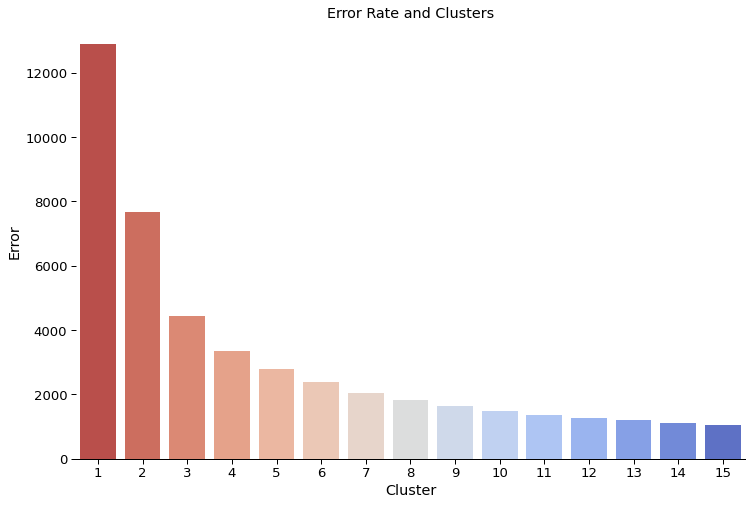

In [108]:
error_rate = []
for clusters in range(1,16):
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(retail_rfm_scaled)
    kmeans.predict(retail_rfm_scaled)
    error_rate.append(kmeans.inertia_)
    
error_rate = pd.DataFrame({'Cluster':range(1,16) , 'Error':error_rate})
plt.figure(figsize=(12,8))
p = sns.barplot(x='Cluster', y= 'Error', data= error_rate, palette='coolwarm_r')
sns.despine(left=True)
p.set_title('Error Rate and Clusters')

In [109]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(retail_rfm_scaled)

KMeans(max_iter=50, n_clusters=3)

In [110]:
# assign the label
retail_rfm['Cluster_Id'] = kmeans.labels_
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id
0,12346.0,0.00,2,325,1,1,1,111,3,Green,others,2
1,12347.0,4310.00,182,1,4,4,4,444,12,Gold,Best Customers,1
2,12348.0,1797.24,31,74,2,2,4,224,8,Silver,others,0
3,12349.0,1757.55,73,18,3,3,4,334,10,Silver,Big Spenders,0
4,12350.0,334.40,17,309,1,1,2,112,4,Green,others,2


In [111]:
retail_rfm.columns

Index(['CustomerID', 'MonetaryValue', 'Frequency', 'Recency', 'R', 'F', 'M',
       'RFM_Segment', 'RFM_Score', 'RFM_Level', 'Segment', 'Cluster_Id'],
      dtype='object')

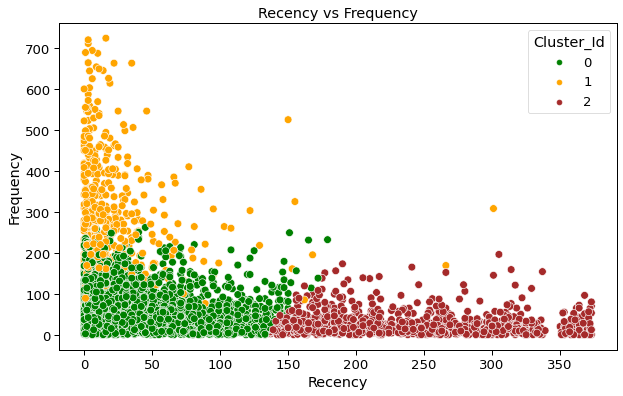

In [112]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Recency',y = 'Frequency',hue="Cluster_Id",  
                 palette=['green','orange','brown'], legend='full',data = retail_rfm  ,s = 60 )
plt.xlabel('Recency')
plt.ylabel('Frequency') 
plt.title('Recency vs Frequency')
plt.show()

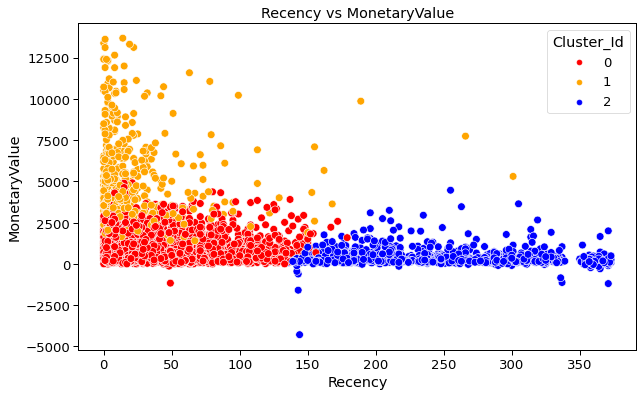

In [113]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Recency',y = 'MonetaryValue',hue="Cluster_Id",  
                 palette=['red','orange','blue'], legend='full',data = retail_rfm  ,s = 60 )
plt.xlabel('Recency')
plt.ylabel('MonetaryValue') 
plt.title('Recency vs MonetaryValue')
plt.show()

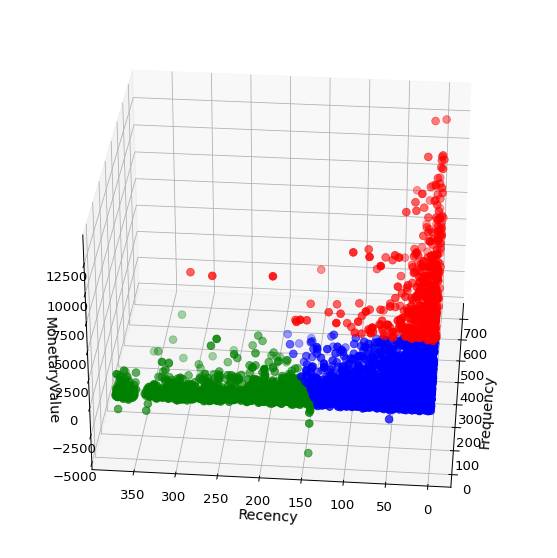

In [115]:
ax = plt.figure(figsize=(20,10)).add_subplot(111, projection='3d')
ax.scatter(retail_rfm.Frequency[retail_rfm.Cluster_Id == 0], retail_rfm["Recency"][retail_rfm.Cluster_Id == 0], retail_rfm["MonetaryValue"][retail_rfm.Cluster_Id == 0], c='blue', s=60)
ax.scatter(retail_rfm.Frequency[retail_rfm.Cluster_Id == 1], retail_rfm["Recency"][retail_rfm.Cluster_Id == 1], retail_rfm["MonetaryValue"][retail_rfm.Cluster_Id == 1], c='red', s=60)
ax.scatter(retail_rfm.Frequency[retail_rfm.Cluster_Id == 2], retail_rfm["Recency"][retail_rfm.Cluster_Id == 2], retail_rfm["MonetaryValue"][retail_rfm.Cluster_Id == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("Frequency")
plt.ylabel("Recency")
ax.set_zlabel('MonetaryValue')
plt.show()

<AxesSubplot:xlabel='Cluster_Id', ylabel='MonetaryValue'>

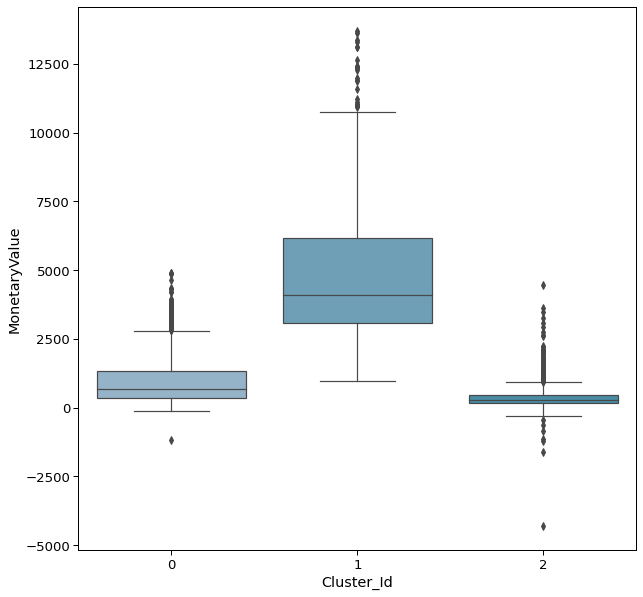

In [116]:
# Box plot to visualize Cluster Id vs Frequency
fig = plt.figure(figsize=(10,10))
sns.boxplot(x='Cluster_Id', y='MonetaryValue', data=retail_rfm)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

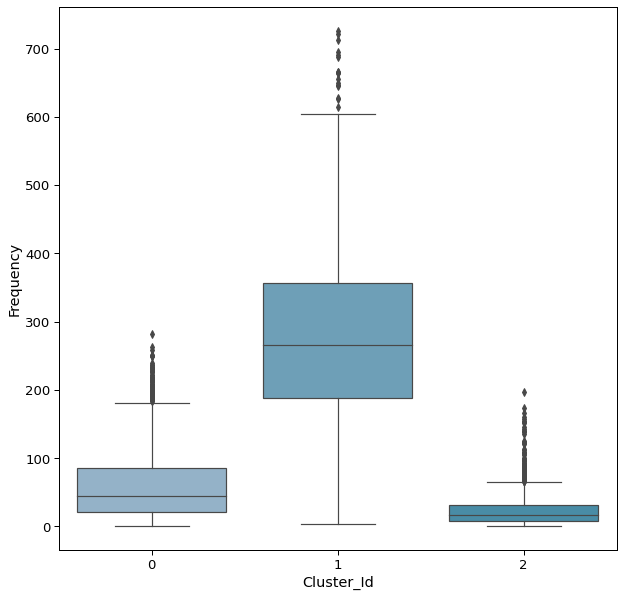

In [117]:
fig = plt.figure(figsize=(10,10))
sns.boxplot(x='Cluster_Id', y='Frequency', data=retail_rfm)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

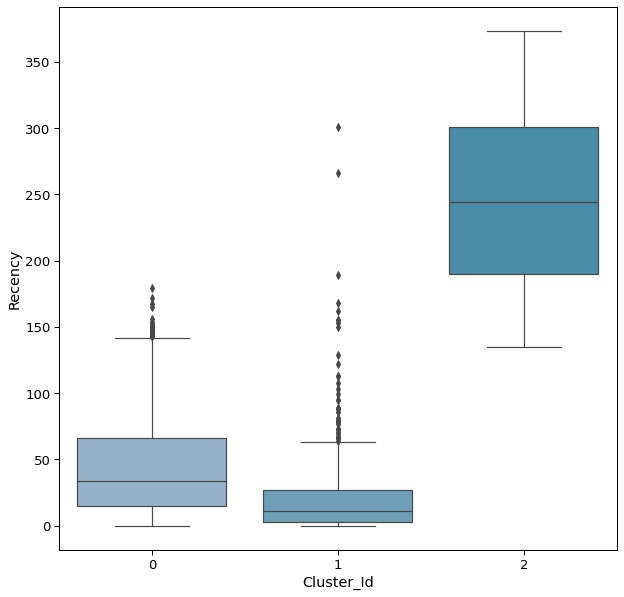

In [118]:
fig = plt.figure(figsize=(10,10))

sns.boxplot(x='Cluster_Id', y='Recency', data=retail_rfm)

# BIRCH Algorithm

In [119]:
retail_rfm.columns

Index(['CustomerID', 'MonetaryValue', 'Frequency', 'Recency', 'R', 'F', 'M',
       'RFM_Segment', 'RFM_Score', 'RFM_Level', 'Segment', 'Cluster_Id'],
      dtype='object')

In [120]:
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id
0,12346.0,0.00,2,325,1,1,1,111,3,Green,others,2
1,12347.0,4310.00,182,1,4,4,4,444,12,Gold,Best Customers,1
2,12348.0,1797.24,31,74,2,2,4,224,8,Silver,others,0
3,12349.0,1757.55,73,18,3,3,4,334,10,Silver,Big Spenders,0
4,12350.0,334.40,17,309,1,1,2,112,4,Green,others,2


In [121]:
retail_rfm_new = retail_rfm[['CustomerID','MonetaryValue','Frequency','Recency']]
retail_rfm_new.head()

,CustomerID,MonetaryValue,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [124]:
from sklearn.cluster import Birch
birch_cluster= Birch(n_clusters=3)
birch_cluster.fit(normalized_df)
labels=birch_cluster.labels_

retail_rfm=pd.concat([retail_rfm, pd.DataFrame({'birch_cluster':labels})], axis=1)
retail_rfm.head()

,CustomerID,MonetaryValue,Frequency,Recency,R,F,M,RFM_Segment,RFM_Score,RFM_Level,Segment,Cluster_Id,birch_cluster
0,12346.0,0.00,2.0,325.0,1,1,1,111,3.0,Green,others,2.0,2.0
1,12347.0,4310.00,182.0,1.0,4,4,4,444,12.0,Gold,Best Customers,1.0,1.0
2,12348.0,1797.24,31.0,74.0,2,2,4,224,8.0,Silver,others,0.0,0.0
3,12349.0,1757.55,73.0,18.0,3,3,4,334,10.0,Silver,Big Spenders,0.0,0.0
4,12350.0,334.40,17.0,309.0,1,1,2,112,4.0,Green,others,2.0,2.0


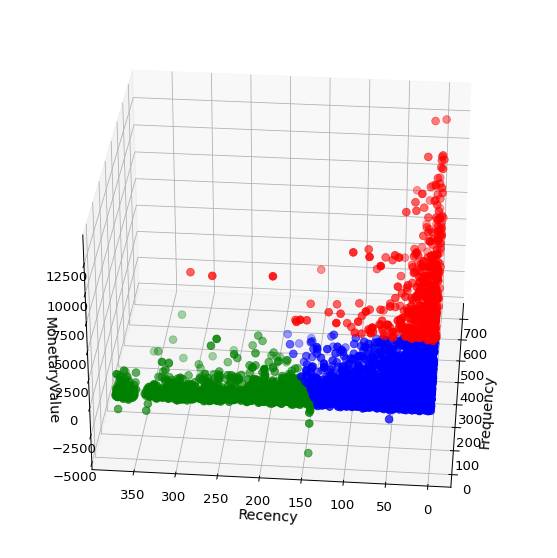

In [125]:

ax = plt.figure(figsize=(20,10)).add_subplot(111, projection='3d')
ax.scatter(retail_rfm.Frequency[retail_rfm.Cluster_Id == 0], retail_rfm["Recency"][retail_rfm.Cluster_Id == 0], retail_rfm["MonetaryValue"][retail_rfm.Cluster_Id == 0], c='blue', s=60)
ax.scatter(retail_rfm.Frequency[retail_rfm.Cluster_Id == 1], retail_rfm["Recency"][retail_rfm.Cluster_Id == 1], retail_rfm["MonetaryValue"][retail_rfm.Cluster_Id == 1], c='red', s=60)
ax.scatter(retail_rfm.Frequency[retail_rfm.Cluster_Id == 2], retail_rfm["Recency"][retail_rfm.Cluster_Id == 2], retail_rfm["MonetaryValue"][retail_rfm.Cluster_Id == 2], c='green', s=60)
ax.view_init(30, 185)
plt.xlabel("Frequency")
plt.ylabel("Recency")
ax.set_zlabel('MonetaryValue')
plt.show()

# DBSCAN Algorithm

In [126]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(normalized_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']
X_principal.head()

,P1,P2
0,0.338330,-0.905890
1,0.821137,0.500059
2,0.939050,-0.217982
3,0.984093,0.110996
4,0.388647,-0.878142


In [127]:

from sklearn.cluster import DBSCAN
db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal)
labels = db_default.labels_

In [128]:
X_principal['P1'].head()

0    0.338330
1    0.821137
2    0.939050
3    0.984093
4    0.388647
Name: P1, dtype: float64

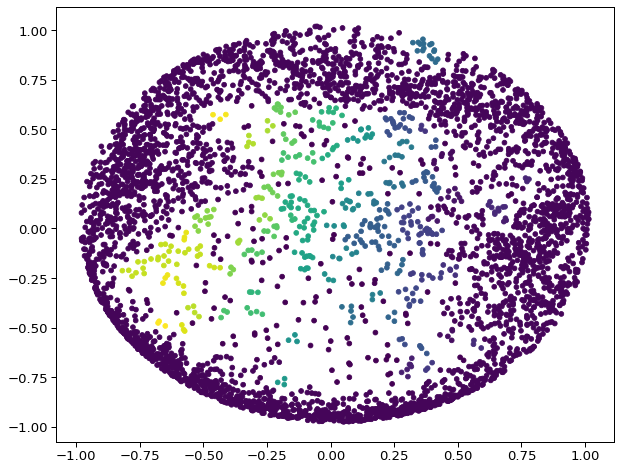

In [129]:
plt.scatter(X_principal['P1'],X_principal['P2'], c=labels)

Text(0, 0.5, 'Distance')

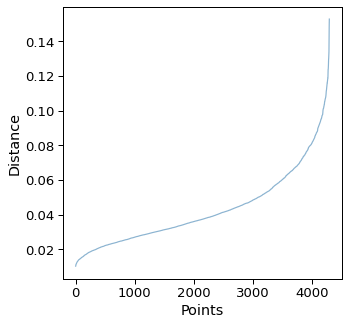

In [130]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_principal)

distances, indices = neighbors.kneighbors(X_principal)
distances = np.sort(distances[:,10], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

0.062388279964817155


<Figure size 360x360 with 0 Axes>

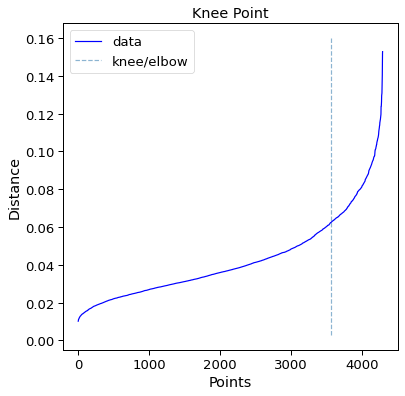

In [132]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

Estimated no. of clusters: 78
Estimated no. of noise points: 162


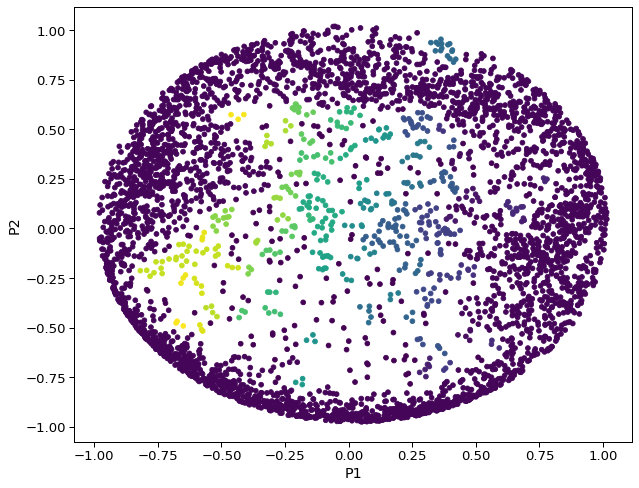

In [133]:
from sklearn.metrics import v_measure_score
dbscan_cluster = DBSCAN(eps=0.062, min_samples=8)
dbscan_cluster.fit(X_principal)

# Visualizing DBSCAN
plt.scatter(X_principal['P1'], X_principal['P2'], c=labels )
plt.xlabel("P1")
plt.ylabel("P2")

# Number of Clusters
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(db_default.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)



# Implementing Market Basket Analysis

In [135]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [136]:
data = df.copy()

In [137]:
#Data clean up which includes removing spaces from some of the descriptions
# Drop the rows that don’t have invoice numbers and remove the credit transactions
data['Description'] = data['Description'].str.strip()
data.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
data['InvoiceNo'] = data['InvoiceNo'].astype('str')
data = data[~data['InvoiceNo'].str.contains('C')]
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [138]:
data['Country'].value_counts()

United Kingdom          349227
Germany                   9027
France                    8327
EIRE                      7228
Spain                     2480
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1453
Australia                 1184
Norway                    1072
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

In [139]:
#After the clean-up, we need to consolidate the items into 1 transaction per row with each product
# For the sake of keeping the data set small, we are only looking at sales for France.
basket = (data[data['Country'] =="EIRE"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
581006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)

basket_sets

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
581006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
#Generate frequent itemsets that have a support value of at least 7% 
# (this number is chosen so that you can get close enough)
# Generate the rules with their corresponding support, confidence and lift.
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.107692,0.130769,0.100000,0.928571,7.100840,0.085917,12.169231
1,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.130769,0.107692,0.100000,0.764706,7.100840,0.085917,3.792308
2,(REGENCY CAKESTAND 3 TIER),(GREEN REGENCY TEACUP AND SAUCER),0.242308,0.130769,0.088462,0.365079,2.791783,0.056775,1.369038
3,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.130769,0.242308,0.088462,0.676471,2.791783,0.056775,2.341958
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.169231,0.130769,0.119231,0.704545,5.387701,0.097101,2.942012


In [142]:
rules.shape

(60, 9)

In [143]:
rules.head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.107692,0.130769,0.100000,0.928571,7.100840,0.085917,12.169231
1,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.130769,0.107692,0.100000,0.764706,7.100840,0.085917,3.792308
2,(REGENCY CAKESTAND 3 TIER),(GREEN REGENCY TEACUP AND SAUCER),0.242308,0.130769,0.088462,0.365079,2.791783,0.056775,1.369038
3,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.130769,0.242308,0.088462,0.676471,2.791783,0.056775,2.341958
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.169231,0.130769,0.119231,0.704545,5.387701,0.097101,2.942012
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.130769,0.169231,0.119231,0.911765,5.387701,0.097101,9.415385
6,(PINK REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.107692,0.242308,0.076923,0.714286,2.947846,0.050828,2.651923
7,(REGENCY CAKESTAND 3 TIER),(PINK REGENCY TEACUP AND SAUCER),0.242308,0.107692,0.076923,0.317460,2.947846,0.050828,1.307335
8,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.107692,0.169231,0.103846,0.964286,5.698052,0.085621,23.261538
9,(ROSES REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.169231,0.107692,0.103846,0.613636,5.698052,0.085621,2.309502
